# Two port parameters
Last update: 26 Apr 2022  

This notebook describes the calculation of two port parameters derived from the circuit's netlist. A [Two-port network](https://en.wikipedia.org/wiki/Two-port_network) is a circuit that has two pairs of ports or terminals and the circuit is characterized by the currents and voltages at the ports by a 2 by 2 matrix. From a two port matrix the response of the network to signals applied to the ports can be calculated easily, without solving for all the internal voltages and currents in the network. For example filters, matching networks, transmission lines, and transistors are characterized by two port parameters.

The first circuit is an attenuator, which could be easily analyzed by hand with a pencil, paper and a calculator, but here I'm using python to step through the calculations. These same steps can be applied to larger, more complex circuits which would be difficult to analyze by hand. The Sympy and SciPy libraries can be used to obtain symbolic and numerical results, however as is shown below, when the circuit is large, symbolic results are not that useful nor do they provide much insight.

The procedure starts by first drawing a schematic of the circuit with a schematic capture program such as EasyEDA (links to the schematics are provided below) then the netlist is generated and exported as a text file. The netlist is used to generate modified nodal equations with the python program described [here](https://github.com/Tiburonboy/Symbolic-modified-nodal-analysis). The equations are solved for voltages and currents at the port terminals by using SymPy to generate the [z-paramters](https://en.wikipedia.org/wiki/Impedance_parameters). Z-parameters are also known as open-circuit impedance parameters as they are calculated under open circuit conditions. Once the z-parameters are obtained, these can be converted into other parameters, such as Y, H, S or others. 

The second circuit is a band pass filter. The filter is designed from a low pass prototype by using normalized values from a filter design handbook. Z and s-parameters are calculated and the results are plotted using Matplotlib.

In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
init_printing()

## Pi-attenuator
The pi-attenuator is formed by three resistors with R1 and R3 as the shunt resistors on the input and output ports and R2 as the series resistor in a circuit topology in the shape of the greek letter pi. For R1 = R3 = 96.25 ohms and R2 equal to 71.15 ohms, the attenuation is 10 dB and the port impedance is 50 ohms. Pasternack's Pi Attenuator Calculator ([Pi pad attenuator](https://www.pasternack.com/t-calculator-pi-attn.aspx)) was used to design the attenuator.

The selection of which type a network parameter is somewhat a matter of convenience. However, some circuits can't have their ports shorted or left open for proper operation, so s-parameters are the appropriate choice in this situation. Solving for the z-parameters is convenient since all we need to do is apply a voltage source to the input port, with the output port unterminated, and solve for the voltage and currents at each port. Since the output port is unterminated, the current into this port is zero and we can find z11 and z21. To find z21 and z22, the voltage source is applied to port 2 with port 1 unterminated. 

To find Z-parameters attach voltage sources to both ports and find the node equations. EasyEDA was used to draw the schematic and generate the netlist. A link to the schematic is [here](https://easyeda.com/editor#id=|6b1460bfe8ec4872b7d7fd3038f38331|82658727399e487c94ebe177746e0ba0).

![schematic](sch_pi_atten_10dB_50ohm.png)

The netlist for the circuit:
```
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
V1 1 0 1
V2 2 0 1
```

### Find z11 & z21
To find $z_{11}$ and $z_{21}$, remove V2 from the net list by commenting out the V2 line in the net list. This will make $I_2$ equal to zero. $z_{11}$ is equal to $\frac{V_1}{I_1}\text{  when  }I_2=0$ and $z_{21}$ is equal to $\frac{V_2}{I_1}\text{  when  }I_2=0$.  

The net list below was run through the NMA code to generate the circuit equations.
```
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
V1 1 0 1
*V2 2 0 1
```

The circuit equations generated are:
```
[[Eq(I_V1 + v1*(1/R2 + 1/R1) - v2/R2, 0)],
[Eq(v2*(1/R3 + 1/R2) - v1/R2, 0)],
[Eq(v1, V1)]]
```

In [2]:
# declare the following symbols
I_V1, R3, R2, V1, v1, R1, v2 = symbols('I_V1 R3 R2 V1 v1 R1 v2')

# use the equations generated by nodal analysis
equ_p1 = Matrix(
    [[Eq(I_V1 + v1*(1/R2 + 1/R1) - v2/R2, 0)],
    [Eq(v2*(1/R3 + 1/R2) - v1/R2, 0)],
    [Eq(v1, V1)]])
equ_p1

⎡          ⎛1    1 ⎞   v₂    ⎤
⎢I_V1 + v₁⋅⎜── + ──⎟ - ── = 0⎥
⎢          ⎝R₂   R₁⎠   R₂    ⎥
⎢                            ⎥
⎢      ⎛1    1 ⎞   v₁        ⎥
⎢   v₂⋅⎜── + ──⎟ - ── = 0    ⎥
⎢      ⎝R₃   R₂⎠   R₂        ⎥
⎢                            ⎥
⎣          v₁ = V₁           ⎦

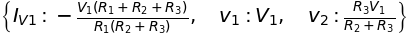

In [3]:
# find symbolic solution
u_p1 = solve(equ_p1,[v1, v2, I_V1])
u_p1

$z_{11} = \frac {V_1}{I_1} \text{  when  } I_2=0$  

A negative sign was placed in the equation to make the direction of the current flow match the definition of the two port parameters.

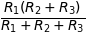

In [4]:
z11 = -u_p1[v1]/u_p1[I_V1]
z11

$z_{21} = \frac {V_2}{I_1} \text{  when  } I_2=0$  

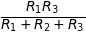

In [5]:
z21 = -u_p1[v2]/u_p1[I_V1]
z21

### Find z12 & z22
To find $z_{12}$ and $z_{22}$, remove V1 from the net list by commenting out the V1 line in the netlist. This will make $I_1$ equal to zero. $z_{12}$ is equal to $\frac{V_1}{I_2}\text{  when  }I_1=0$ and $z_{22}$ is equal to $\frac{V_2}{I_2}\text{  when  }I_1=0$.  

The net list below was run through the NMA code to generate the circuit equations.

Remove V1 from the net list.
```
R1 0 1 96.25
R2 1 2 71.15
R3 0 2 96.25
*V1 1 0 1
V2 2 0 1
```

The circuit equations generated by the MNA python code.
```
[[Eq(v1*(1/R2 + 1/R1) - v2/R2, 0)],
[Eq(I_V2 + v2*(1/R3 + 1/R2) - v1/R2, 0)],
[Eq(v2, V2)]]
```

In [6]:
# declare the following symbols
R3, R2, V2, v1, R1, I_V2, v2 = symbols('R3 R2 V2 v1 R1 I_V2 v2')

# use the equations generated by nodal analysis
equ_p2 = Matrix(
    [[Eq(v1*(1/R2 + 1/R1) - v2/R2, 0)],
    [Eq(I_V2 + v2*(1/R3 + 1/R2) - v1/R2, 0)],
    [Eq(v2, V2)]])
equ_p2

⎡      ⎛1    1 ⎞   v₂        ⎤
⎢   v₁⋅⎜── + ──⎟ - ── = 0    ⎥
⎢      ⎝R₂   R₁⎠   R₂        ⎥
⎢                            ⎥
⎢          ⎛1    1 ⎞   v₁    ⎥
⎢I_V2 + v₂⋅⎜── + ──⎟ - ── = 0⎥
⎢          ⎝R₃   R₂⎠   R₂    ⎥
⎢                            ⎥
⎣          v₂ = V₂           ⎦

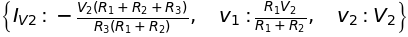

In [7]:
# find symbolic solution
u_p2 = solve(equ_p2,[v1, v2, I_V2])
u_p2

$z_{12}=\frac{V_1}{I_2}\text{  when  }I_1=0$ 

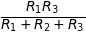

In [8]:
z12 = -u_p2[v1]/u_p2[I_V2]
z12

$z_{22}=\frac{V_2}{I_2}\text{  when  }I_1=0$  

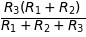

In [9]:
z22 = -u_p2[v2]/u_p2[I_V2]
z22

The common names for the z-parameters are:  
z11: input driving point impedance  
z12: reverse transfer impedance  
z21: forward transfer impedance  
z22: output driving point impedance  

The elements of the matrix can be displayed:

In [10]:
Matrix([[z11,z21],[z12,z22]])

⎡R₁⋅(R₂ + R₃)     R₁⋅R₃    ⎤
⎢────────────  ────────────⎥
⎢R₁ + R₂ + R₃  R₁ + R₂ + R₃⎥
⎢                          ⎥
⎢   R₁⋅R₃      R₃⋅(R₁ + R₂)⎥
⎢────────────  ────────────⎥
⎣R₁ + R₂ + R₃  R₁ + R₂ + R₃⎦

Actual values for each of the components can be substituted for the symbols with R1 = R3 = 96.25 ohms and R2 equal to 71.15 ohms

In [11]:
atten_values = {R1:96.25,R2:71.15,R3:96.25}

In [12]:
z11_val = z11.subs(atten_values)
z12_val = z12.subs(atten_values)
z21_val = z21.subs(atten_values)
z22_val = z22.subs(atten_values)

The numeric values of the impedance matrix

In [13]:
np.array([[z11_val, z12_val],[z21_val, z22_val]],dtype=np.float)

array([[61.11227005, 35.13772995],
       [35.13772995, 61.11227005]])

## Calculate Z in and Z out, ki and kv
A two-port circuit is typically driven at port 1 and loaded at port 2, and four equations needed to solve the four unknowns.

$\begin{align*}
\begin{bmatrix} -1 & 0 & z11 & z12 \\\ 0 & -1 & z21 & z22 \\\ 1 & 0 & Z_S & 0 \\\ 0 & 1 & 0 & Z_L    
\end{bmatrix}
\begin{bmatrix}
  V_1  \\
  V_2  \\
  I_1 \\
  I_2
\end{bmatrix}
{} &= \begin{bmatrix}
  0  \\
  0  \\
  V_g \\
  0
\end{bmatrix}
\end{align*}$

Reference: https://www.ee.nthu.edu.tw/~sdyang/Courses/Circuits/Ch18_Std.pdf

Putting into SymPy  

In [14]:
Z11, Z12, Z21, Z22 = symbols('Z11 Z12 Z21 Z22')
Z_s, Z_l, Vg = symbols('Z_s Z_l Vg')

eqZ = Eq(Matrix([[-1,0,Z11,Z12],[0,-1,Z21,Z22],[1,0,Z_s,0],[0,1,0,Z_l]])*Matrix([V1,V2,I_V1,I_V2]),Matrix([0,0,Vg,0]))
eqZ

⎡I_V1⋅Z₁₁ + I_V2⋅Z₁₂ - V₁⎤   ⎡0 ⎤
⎢                        ⎥   ⎢  ⎥
⎢I_V1⋅Z₂₁ + I_V2⋅Z₂₂ - V₂⎥   ⎢0 ⎥
⎢                        ⎥ = ⎢  ⎥
⎢      I_V1⋅Zₛ + V₁      ⎥   ⎢Vg⎥
⎢                        ⎥   ⎢  ⎥
⎣      I_V2⋅Zₗ + V₂      ⎦   ⎣0 ⎦

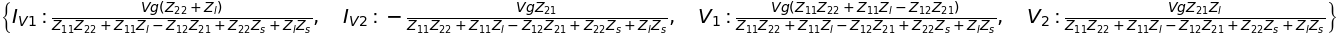

In [15]:
ansZ = solve(eqZ,[V1, V2, I_V1,I_V2])
ansZ

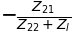

In [16]:
# current gain
ansZ[I_V2]/ansZ[I_V1]

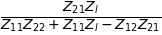

In [17]:
# voltage gain
ansZ[V2]/ansZ[V1]

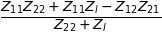

In [18]:
# Z input
ansZ[V1]/ansZ[I_V1]

In [19]:
# Z out
ansZ[V2]/ansZ[I_V2]

Sympy returns the output impedance as simply $-Z_l$, since this is the algebraic simplification of the equations. Most textbooks will give the output impedance in terms of the z-parameters and the source impedance: $Z_{out}=Z_{22}-\frac{Z_{12}Z_{21}}{Z_{11}+Z_{S}}$

## Calculate input and output impedance for the attenuator
The input impedance of a two-port network is: $Z_{in}=\frac{Z_{11}Z_{22}+Z_{11}Z_{L}-Z_{12}Z_{21}}{Z_{22}+Z_{L}}$  
Textbook equation: $Z_{in}=Z_{11}-\frac{Z_{12}Z_{21}}{Z_{22}+Z_{L}}$
where $Z_{L}$ is the impedance of the load connected to port two.

The output impedance from textbooks is: $Z_{out}=Z_{22}-\frac{Z_{12}Z_{21}}{Z_{11}+Z_{S}}$, where $Z_{S}$ is the impedance of the source connected to port one.

In [20]:
# Zin
Zl = 50 # load impedance
print('input impedance of network from z-parameters: {:.2f}'.format(np.abs((z11_val*z22_val+z11_val*Zl-z12_val*z21_val)/(z22_val+Zl))))

input impedance of network from z-parameters: 50.00


In [21]:
# Zout
Zs = 50 # source impedance
print('output impedance of network from z-parameters: {:.2f}'.format(np.abs(z22_val-(z12_val*z21_val)/(z11_val+Zs))))

output impedance of network from z-parameters: 50.00


## Calculate the voltage gain for the attenuator
Voltage gain: $K_v=\frac{Z_{21}Z_{L}}{Z_{11}Z_{22}+Z_{11}Z_{L}-Z_{12}Z_{21}}$, from text books: $K_v=\frac{Z_{21}Z_{L}}{\Delta _Z+Z_{11}Z_L}$

In [22]:
#Kv
print('voltage gain of network from z-parameters: {:.2f} dB'.format(20*np.log10(float((z21_val*Zl)/(z11_val*z22_val + z11_val*Zl - z12_val*z21_val)))))

voltage gain of network from z-parameters: -10.00 dB


## Convert z-parameters to y-parameters
The z-parameters can be converted to admittance or y-parameters with the following code:

Find the determinant of the z-parameter matrix:

In [23]:
det_z = np.linalg.det(np.array([[z11_val, z12_val],[z21_val, z22_val]],dtype=np.float))
print('determinant = {:.2f}'.format(det_z))

determinant = 2500.05


Display the y-parameter matrix.

In [24]:
np.array([[z22_val/det_z,-z12_val/det_z],[-z21_val/det_z,z11_val/det_z]],dtype=np.float)

array([[ 0.02444442, -0.01405481],
       [-0.01405481,  0.02444442]])

### Convert z-parameters to s-parameters
The 2-port S-parameters have the following generic descriptions:  
$S_{11} \text{ is the input port voltage reflection coefficient}$  
$S_{12} \text{ is the reverse voltage gain}$  
$S_{21} \text{ is the forward voltage gain}$  
$S_{22} \text{ is the output port voltage reflection coefficient}$  

The z-parameter can be converted to scattering or s-parameters with the following:  
$s_{11} = \frac {(Z_{11}-Z_o)(Z_{22}+Z_o)-Z_{12}Z_{21}} {\Delta Z}$  
$s_{12} = \frac {2Z_{12}Z_o} {\Delta Z}$  
$s_{21} = \frac {2Z_{21}Z_o} {\Delta Z}$  
$s_{22} = \frac {(Z_{11}+Z_o)(Z_{22}-Z_o)-Z_{12}Z_{21}} {\Delta Z}$  
where: $\Delta Z = (Z_{11}+Z_o)(Z_{22}+Z_o)-Z_{12}Z_{21}$ and $Z_o$ is the characteristic impedance.

In [25]:
Z_o = 50 # characteristic impedance
del_z = (z11_val+Z_o)*(z22_val+Z_o)-z12_val*z21_val

S = np.array([[((z11_val-Z_o)*(z22_val-Z_o)-z12_val*z21_val)/del_z,(2*z12_val*Z_o)/del_z],
              [(2*z21_val*Z_o)/del_z,((z11_val+Z_o)*(z22_val-Z_o)-z12_val*z21_val)/del_z]],dtype=np.float)
S # display the s-parameter matrix

array([[-1.00004488e-01,  3.16234863e-01],
       [ 3.16234863e-01,  4.45363654e-06]])

#### Input return loss
Input return loss $RL_{in}$ indicates impedance match of the port to the source. A number of 10 dB or greater, indicates that the match is probably acceptable.

$RL_{in} =-20\log_{10}\left|S_{11}\right|$

In [26]:
print('Input return loss = {:.2f} dB'.format(-20*np.log10(np.abs(S[0,0]))))

Input return loss = 20.00 dB


#### Insertion loss
Insertion loss $IL$ is the reciprocal of the magnitude of the transmission coefficient, S21, expressed in decibels.

$IL=-20\log _{10} \left|S_{21} \right|$

In [27]:
print('Insertion loss = {:.2f} dB'.format(-20*np.log10(np.abs(S[1,0]))))

Insertion loss = 10.00 dB


This value agrees with the design of the attenuator as being a 10 dB attenuator.

## Band Pass Filter
The circuit below is a band pass filter designed from normalized filter design tables. The third order low pass filter prototype was transformed into a bandpass filter as shown in the figure below. [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter) filter coefficients were chosen for this design. A Butterworth filter is a type of signal processing filter that has a flat passband response.

![schematic](Sch_Two_port_circuit_BPF.PNG)

The link to the schematic in EasyEDA is [here](https://easyeda.com/editor#mode=sim,id=|6b1460bfe8ec4872b7d7fd3038f38331|82658727399e487c94ebe177746e0ba0|ea67be55cc5c49f288edfa4ed837b1f0|8ea3b89798114238a453a1c678008c07|bef561e1caa74d498d621a82362fc683|3b000d947aad4568aba52d9cefa5715c).

The low pass to bandpass transformation calculations are shown below. The filter was designed to have a center frequency of 10 MHz and a 3 dB bandwidth of 1 MHz. The normalized filter values were obtained from [1] and are: 
```
3rd order Butterworth LPF prototype
Rs/Rl = 1
C1 = 1
L2 = 2
C1 = 1
```

The bandpass filter has the following design parameters: The source and load impedance is 50 ohms, the filter bandwidth is 1 MHz and the center frequency is 10 MHz. Following example 5-2 of reference [1], but with the following changes:   

- center freq = 10MHz  
- bandwidth 1MHz  
- Rs=Rl=50  

Reference:  
1) Electronic Filter Design Handbook, 3rd edition, McGraw-Hill, 1995  

In [28]:
f_center = 10e6
f_3dB_BW = 1e6 # 3dB bandwidth
fo = np.sqrt((f_center-f_3dB_BW/2)*(f_center+f_3dB_BW/2)) # geometric center frequency
print('geometric center frequency = {:.3f}MHz'.format(fo/1e6))

geometric center frequency = 9.987MHz


In [29]:
Z = 50 # load and source resistance
FSF = 2*np.pi*f_3dB_BW
print('frequency scaling factor = {:.3f}'.format(FSF))

frequency scaling factor = 6283185.307


The first element in the lowpass prototype is a shunt inductor and for the lowpass to bandpass transformation the inductor is replaced by a capacitor and inductor in parallel with the same normalized value. The normalized values are then frequency scaled.

In [30]:
# C1 is 1st shunt capacitor
C1n = 1 # normalized value from the tables in the filter handbook
C1p = C1n/(FSF*Z)
print('capacitor = {:.3f}nF'.format(C1p*1e9))

wo = 2*np.pi*fo
L1p = 1/(wo**2*C1p) # calculate the value of the inductor that resonates with the capacitor at the center frequency
print('inductor = {:.3f}nH'.format(L1p*1e9))

capacitor = 3.183nF
inductor = 79.777nH


The second element in the lowpass prototype is a series capacitor and for the lowpass to bandpass transformation the capacitor is replaced by a capacitor and inductor in series with the same normalized value. The normalized values are then frequency scaled.

In [31]:
# L2 is the 2nd series inductor
L2n = 2 # normalized value from the tables in the filter handbook
L2p = L2n*Z/FSF
print('inductor = {:.3f}uH'.format(L2p*1e6))

C2p = 1/(wo**2*L2p) # calculate the value of the capacitor that resonates with the inductor at the center frequency
print('capacitor = {:.3f}pF'.format(C2p*1e12))

inductor = 15.915uH
capacitor = 15.955pF


The last element in the lowpass prototype is a shunt inductor and for the lowpass to bandpass transformation the inductor is replaced by a capacitor and inductor in parallel with the same normalized value. The normalized values are then frequency scaled. The values for this branch of the circuit are the same as for the first shunt element.

## Find z11 and z12
To find $z_{11}$ and $z_{21}$, remove V2 from the net list by commenting out the V2 line in the net list. This will make $I_2$ equal to zero. $z_{11}$ is equal to $\frac{V_1}{I_1}\text{  when  }I_2=0$ and $z_{21}$ is equal to $\frac{V_2}{I_1}\text{  when  }I_2=0$.  

The net list below was run through the NMA code to generate the circuit equations. The component values in the netlist have all been set to one. Later, the actual component values will be used. 

```
V1 1 0 1
*V2 2 0 1
L1 0 1 1
L2 1 3 1
L3 0 2 1
C1 1 0 1
C2 3 2 1
C3 2 0 1
```

The circuit equations generated are:
```
[[Eq(C1*s*v1 - I_L1 + I_L2 + I_V1, 0)],
[Eq(-C2*s*v3 - I_L3 + v2*(C2*s + C3*s), 0)],
[Eq(-C2*s*v2 + C2*s*v3 - I_L2, 0)],
[Eq(v1, V1)],
[Eq(-I_L1*L1*s - v1, 0)],
[Eq(-I_L2*L2*s + v1 - v3, 0)],
[Eq(-I_L3*L3*s - v2, 0)]]
```

In [32]:
# declare the following symbols
L2, I_L2, v2, v1, I_V1, C1, C3, v3, V1, L1, I_L3, s, C2, L3, I_L1 = symbols('L2 I_L2 v2 v1 I_V1 C1 C3 v3 V1 L1 I_L3 s C2 L3 I_L1')

# use the equations generated by nodal analysis
equ_p1 = Matrix(
    [[Eq(C1*s*v1 - I_L1 + I_L2 + I_V1, 0)],
    [Eq(-C2*s*v3 - I_L3 + v2*(C2*s + C3*s), 0)],
    [Eq(-C2*s*v2 + C2*s*v3 - I_L2, 0)],
    [Eq(v1, V1)],
    [Eq(-I_L1*L1*s - v1, 0)],
    [Eq(-I_L2*L2*s + v1 - v3, 0)],
    [Eq(-I_L3*L3*s - v2, 0)]])
equ_p1

⎡   C₁⋅s⋅v₁ - I_L1 + I_L2 + I_V1 = 0   ⎤
⎢                                      ⎥
⎢-C₂⋅s⋅v₃ - I_L3 + v₂⋅(C₂⋅s + C₃⋅s) = 0⎥
⎢                                      ⎥
⎢    -C₂⋅s⋅v₂ + C₂⋅s⋅v₃ - I_L2 = 0     ⎥
⎢                                      ⎥
⎢               v₁ = V₁                ⎥
⎢                                      ⎥
⎢         -I_L1⋅L₁⋅s - v₁ = 0          ⎥
⎢                                      ⎥
⎢       -I_L2⋅L₂⋅s + v₁ - v₃ = 0       ⎥
⎢                                      ⎥
⎣         -I_L3⋅L₃⋅s - v₂ = 0          ⎦

At this point we can use the power of SymPy and obtain a symbolic solution, but as you can see the results don't seem that useful.

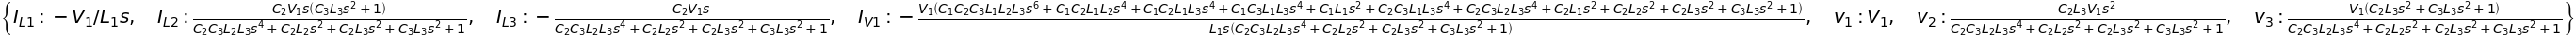

In [33]:
solve(equ_p1,[v1, v2, v3, I_V1, I_L1, I_L2, I_L3])

In [34]:
element_values = {L1:L1p,C1:C1p,C2:C2p,L2:L2p,L3:L1p,C3:C1p}

Substituting actual values for the circuit elements, we get:

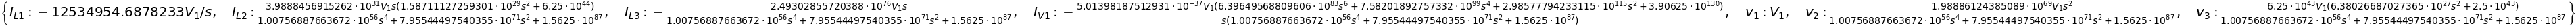

In [35]:
# find solution
u_p1 = solve(equ_p1.subs(element_values),[v1, v2, v3, I_V1, I_L1, I_L2, I_L3])
u_p1

$z_{11} = \frac {V_1}{I_1} \text{  when  } I_2=0$  

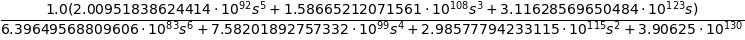

In [36]:
z11 = -u_p1[v1]/u_p1[I_V1]
z11.simplify()

$z_{21} = \frac {V_2}{I_1} \text{  when  } I_2=0$  

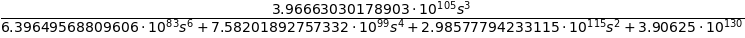

In [37]:
z21 = -u_p1[v2]/u_p1[I_V1]
z21.simplify()

## Find z12 & z22
To find $z_{12}$ and $z_{22}$, remove V1 from the net list by commenting out the V1 line in the netlist. This will make $I_1$ equal to zero. $z_{12}$ is equal to $\frac{V_1}{I_2}\text{  when  }I_1=0$ and $z_{22}$ is equal to $\frac{V_2}{I_2}\text{  when  }I_1=0$.  

The net list below was run through the NMA code to generate the circuit equations.

Remove V1 from the netlist.  
```
*V1 1 0 1
V2 2 0 1
L1 0 1 1
L2 1 3 1
L3 0 2 1
C1 1 0 1
C2 3 2 1
C3 2 0 1
```

The circuit equations generated by the MNA python code.  
```
[[Eq(C1*s*v1 - I_L1 + I_L2, 0)],
[Eq(-C2*s*v3 - I_L3 + I_V2 + v2*(C2*s + C3*s), 0)],
[Eq(-C2*s*v2 + C2*s*v3 - I_L2, 0)],
[Eq(v2, V2)],
[Eq(-I_L1*L1*s - v1, 0)],
[Eq(-I_L2*L2*s + v1 - v3, 0)],
[Eq(-I_L3*L3*s - v2, 0)]]
```

In [38]:
# declare the following symbols
V2, L2, I_L2, v2, v1, C1, C3, L1, v3, I_L3, s, C2, L3, I_V2, I_L1 = symbols('V2 L2 I_L2 v2 v1 C1 C3 L1 v3 I_L3 s C2 L3 I_V2 I_L1')

# use the equations generated by nodal analysis
equ_p2 = Matrix(
    [[Eq(C1*s*v1 - I_L1 + I_L2, 0)],
    [Eq(-C2*s*v3 - I_L3 + I_V2 + v2*(C2*s + C3*s), 0)],
    [Eq(-C2*s*v2 + C2*s*v3 - I_L2, 0)],
    [Eq(v2, V2)],
    [Eq(-I_L1*L1*s - v1, 0)],
    [Eq(-I_L2*L2*s + v1 - v3, 0)],
    [Eq(-I_L3*L3*s - v2, 0)]])
equ_p2

⎡          C₁⋅s⋅v₁ - I_L1 + I_L2 = 0          ⎤
⎢                                             ⎥
⎢-C₂⋅s⋅v₃ - I_L3 + I_V2 + v₂⋅(C₂⋅s + C₃⋅s) = 0⎥
⎢                                             ⎥
⎢        -C₂⋅s⋅v₂ + C₂⋅s⋅v₃ - I_L2 = 0        ⎥
⎢                                             ⎥
⎢                   v₂ = V₂                   ⎥
⎢                                             ⎥
⎢             -I_L1⋅L₁⋅s - v₁ = 0             ⎥
⎢                                             ⎥
⎢          -I_L2⋅L₂⋅s + v₁ - v₃ = 0           ⎥
⎢                                             ⎥
⎣             -I_L3⋅L₃⋅s - v₂ = 0             ⎦

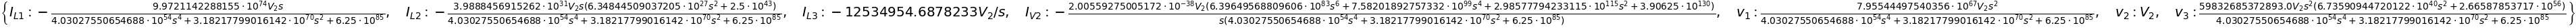

In [39]:
# find symbolic solution
u_p2 = solve(equ_p2.subs(element_values),[v1, v2, v3, I_V2, I_L1, I_L2, I_L3])
u_p2

$z_{12} = \frac {V_1}{I_2} \text{  when  } I_1=0$ 

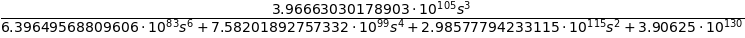

In [40]:
z12 = -u_p2[v1]/u_p2[I_V2]
z12.simplify()

$z_{22} = \frac {V_2}{I_2} \text{  when  } I_1=0$  

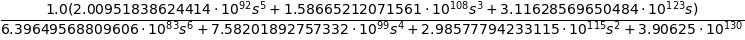

In [41]:
z22 = -u_p2[v2]/u_p2[I_V2]
z22.simplify()

displaying  the z-parameter matrix

In [42]:
Matrix([[z11,z21],[z12,z22]])

⎡                         ⎛                      4                         2  
⎢   1.9944228457631e+36⋅s⋅⎝1.00756887663672e+56⋅s  + 7.95544497540355e+71⋅s  +
⎢─────────────────────────────────────────────────────────────────────────────
⎢                      6                         4                          2 
⎢6.39649568809606e+83⋅s  + 7.58201892757332e+99⋅s  + 2.98577794233115e+115⋅s  
⎢                                                                             
⎢                                                         3                   
⎢                                  3.96663030178903e+105⋅s                    
⎢─────────────────────────────────────────────────────────────────────────────
⎢                      6                         4                          2 
⎣6.39649568809606e+83⋅s  + 7.58201892757332e+99⋅s  + 2.98577794233115e+115⋅s  

           ⎞                                                             3    
 1.5625e+87⎠                                      3

The complete z-parameter matrix is shown above. It's kind of interesting that the exponents on many of the coefficients are so large. Using the SymPy function lambdify to turn the symbolic expression into a function.

In [43]:
func_z11_s = lambdify(s, z11)
func_z12_s = lambdify(s, z12) 
func_z21_s = lambdify(s, z21) 
func_z22_s = lambdify(s, z22) 

Using the results from above, the input impedance of a two-port network is given by:
The input impedance of a two-port network is: $Z_{in}=\frac{Z_{11}Z_{22}+Z_{11}Z_{L}-Z_{12}Z_{21}}{Z_{22}+Z_{L}}$, where $Z_{L}$ is the impedance of the load connected to port two.

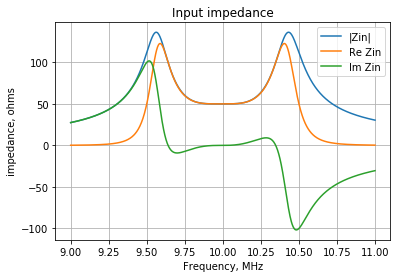

In [44]:
# set the source and load impedance
Zl = Zs = 50

w = np.linspace(9e6*2*np.pi, 11e6*2*np.pi, 1000, endpoint=True)

plt.title('Input impedance')

plt.plot(w/(2*np.pi)/1e6, np.abs((func_z11_s(1j*w)*func_z22_s(1j*w)+func_z11_s(1j*w)*Zl-func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z22_s(1j*w)+Zl)),'-',label='|Zin|')
plt.plot(w/(2*np.pi)/1e6, np.real((func_z11_s(1j*w)*func_z22_s(1j*w)+func_z11_s(1j*w)*Zl-func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z22_s(1j*w)+Zl)),'-',label='Re Zin')
plt.plot(w/(2*np.pi)/1e6, np.imag((func_z11_s(1j*w)*func_z22_s(1j*w)+func_z11_s(1j*w)*Zl-func_z12_s(1j*w)*func_z21_s(1j*w))/(func_z22_s(1j*w)+Zl)),'-',label='Im Zin')

plt.ylabel('impedance, ohms')
plt.xlabel('Frequency, MHz')
plt.legend()
plt.grid()
plt.show()

The plot above shows the magnitude of the input impedance (in blue), the real part of the input impedance (in orange) and the imaginary part of the input impedance (in green). Near 10Hz, the magnitude and real part of the input impedance is 50 ohms and the imaginary part is about zero. This shows that the design equations produced the desired results. The input impedance bandwidth of the filter is about 1 MHz.

The voltage gain of the filter calculated from the z-parameters is: $K_v=\frac{Z_{21}Z_{L}}{Z_{11}Z_{22}+Z_{11}Z_{L}-Z_{12}Z_{21}}$, which is plotted below:

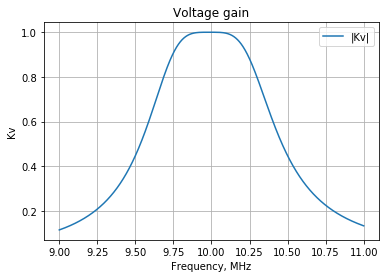

In [45]:
plt.title('Voltage gain')
plt.plot(w/(2*np.pi)/1e6, np.abs((func_z21_s(1j*w)*Zl)/(func_z11_s(1j*w)*func_z22_s(1j*w)+func_z11_s(1j*w)*Zl-func_z12_s(1j*w)*func_z21_s(1j*w))),'-',label='|Kv|')
plt.ylabel('Kv')
plt.xlabel('Frequency, MHz')
plt.legend()
plt.grid()
plt.show()

The plot above shows the voltage gain of the filter (in blue) plotted from the z-parameters. The filter is centered at 10MHz and the bandwidth appears to be 1 MHz. 

## Convert z-parameters to s-parameters
Although applicable at any frequency, s-parameters are mostly used for networks operating at radio frequency (RF) and microwave frequencies. The s-parameters can be calculated from the z-parameters with the following formulas:

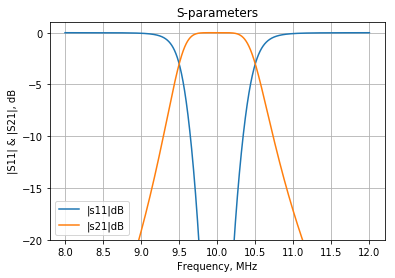

In [46]:
Z_o = 50 # characteristic impedance

w = np.linspace(8e6*2*np.pi, 12e6*2*np.pi, 2000, endpoint=True)
s11 = np.zeros(len(w),dtype=complex)
s12 = np.zeros(len(w),dtype=complex)
s21 = np.zeros(len(w),dtype=complex)
s22 = np.zeros(len(w),dtype=complex)

for i in range(len(w)):
    del_z = (func_z11_s(1j*w[i])+Z_o)*(func_z22_s(1j*w[i])+Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i])
    s11[i] = ((func_z11_s(1j*w[i])-Z_o)*(func_z22_s(1j*w[i])+Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i]))/del_z
    s12[i] = (2*func_z12_s(1j*w[i])*Z_o)/del_z
    s21[i] = (2*func_z21_s(1j*w[i])*Z_o)/del_z
    s22[i] = ((func_z11_s(1j*w[i])+Z_o)*(func_z22_s(1j*w[i])-Z_o)-func_z12_s(1j*w[i])*func_z21_s(1j*w[i]))/del_z

plt.title('S-parameters')
plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s11)),'-',label='|s11|dB')
plt.plot(w/(2*np.pi)/1e6, 20*np.log10(np.abs(s21)),'-',label='|s21|dB')
plt.ylabel('|S11| & |S21|, dB')
plt.xlabel('Frequency, MHz')
plt.ylim((-20,1))
plt.yticks(np.arange(-20, 1, 5))
#plt.xlim((-1,20))
#plt.xticks(np.arange(0, 20+1, 2.0))
plt.legend()
plt.grid()
plt.show()

The plot above shows the magnitudes in dB of the input reflection coefficient (in blue) and the forward voltage gain (in orange). 

The magnitude of the input reflection coefficient indicates the amount of energy reflected back to the source due to the impedance mismatch. The smaller the reflection coefficient the better the match, and in dB, large negative values are very small small numbers. A rule of thumb is that |S11| less than about -9.5 dB is a reasonable match, since this corresponds to about a 2:1 VSWR or a mismatch loss of about 0.5 dB. The frequency range over which this match occurs is called the impedance bandwidth. 

The plot of |S21| shows the forward voltage gain of the filter in dB. The filter was designed to be a band pass filter with a center frequency of 10 MHz, which is clearly shown in the plot. The plot is similar to what would be seen on a network analyzer. 

## Summary
In this notebook the parameters for two port networks were generated from the circuit's netlist. Using python, the circuit equations were automatically generated by using modified nodal analysis, then SymPy was used to solve for the network currents and voltages. Z-parameters were calculated for the circuits, from which y and s parameters were generated. The z-parameters were used to generate input impedance and transfer functions.

This notebook has demonstrated that two port parameters can easily be generated from a circuit's netlist with python. 